<a href="https://colab.research.google.com/github/helonayala/sysid/blob/main/multiple_shooting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple shooting

This notebook demonstrates grey-box system identification using **multiple shooting**. We apply this method to a simple linear DC motor to estimate its physical parameters from synthetically generated data.

The process involves:
1. Formulating the mathematical problem for system identification.
2. Defining the specific DC motor model.
3. Generating a multisine excitation signal and simulating the system's response to create data.
4. Implementing the optimization problem using the JAX framework for automatic differentiation and a `diffrax` for the ODE solver.
5. Solving the optimization problem to find the physical parameters and validating the results.

## Future improvements

* currently we support only full state measurement, in the future we may add the measurement equation in the formulation too

## 1. Mathematical Problem Formulation

### Grey-Box Modeling

We consider a system described by a set of Ordinary Differential Equations (ODEs):

$$ \dot{x}(t) = f(x(t), u(t), \theta) $$

where:
- $x(t)$ is the state vector at time $t$.
- $u(t)$ is the input vector at time $t$.
- $\theta$ is the vector of unknown physical parameters we wish to identify.

Given a set of measurements of the states $x_{m}(t_k)$ at discrete time points $t_k$, the goal is to estimate the parameter vector $\hat{\theta}$ that minimizes the discrepancy between the model's prediction $\hat{x}(t)$ and $x_{m}(t_k)$.

### Multiple Shooting for Parameter Estimation

**Single shooting** refers to using an initial guess for $\theta$, simulating the system over the entire time horizon from a known initial state $x(0)$ (drafted from measured data), and minimizing the error. However, this method is not advisable for complex systems or long-duration datasets, as the objective function can grow in complexity very quickly, among other factors.

**Multiple shooting** does not rely on function composition entirely. The time horizon $[t_0, t_f]$, which contains $N$ discrete time points, is divided into $M$ smaller, non-overlapping intervals. For each interval $i \in \{0, 1, ..., M-1\}$, we introduce a local initial state variable, $s_i$.

The optimization problem for MS is then formulated as follows:

**Decision Variables:**
They include the parameters $\theta$ and the initial state for each of the $M$ intervals:

$$X = \{ \theta, s_0, s_1, \dots, s_{M-1} \}$$

**Objective Function:**
The objective is to minimize the sum of squared errors between the model predictions within each interval and the corresponding measurements. Let $K_i$ be the set of discrete time indices $\{k\}$ belonging to the $i$-th shooting interval. The objective is then:

$$J(X) = \sum_{i=0}^{M-1} \sum_{k \in K_i} \| \hat{x}(t_k; s_i, \theta) - x_{m}(t_k) \|^2$$

where $\hat{x}(t_k; s_i, \theta)$ is the state predicted by the model at time point $t_k$, which is the result of integrating the system dynamics from the initial state $s_i$ at the start of the interval, $t_i$.

**Equality Constraints:**
To ensure the overall trajectory is continuous and physically valid according to the model, we enforce *continuity constraints* (or *defect constraints*) between adjacent intervals. The state predicted at the end of interval $i$ must be equal to the initial state variable $s_{i+1}$ of interval $i+1$.

$$s_{i+1} - F(s_i, u_i, \theta) = 0 \quad \forall i \in \{0, 1, ..., M-2\}$$

where $F(s_i, u_i, \theta)$ represents the result of integrating the ODE system $\dot{x} = f(x, u, \theta)$ over the entire duration of interval $i$. It is a shorthand for the predicted state at the end of the interval, making it equivalent to $\hat{x}(t_{i+1}; s_i, \theta)$.

This constrained nonlinear programming (NLP) problem is numerically more stable and often converges faster than single shooting, especially when solved with gradient-based methods leveraging automatic differentiation.

### Complete NLP Formulation

Summing up, the complete Nonlinear Programming (NLP) problem being solved can be summarized as:

$$
\begin{aligned}
\min_{X} \quad & \sum_{i=0}^{M-1} \sum_{k \in K_i} \| \hat{x}(t_k; s_i, \theta) - x_{m}(t_k) \|^2 \\
\text{subject to} \quad & s_{i+1} - F(s_i, u_i, \theta) = 0, \quad \forall i \in \{0, 1, ..., M-2\}
\end{aligned}
$$

where:
* $X = \{ \theta, s_0, s_1, \dots, s_{M-1} \}$ is the set of all decision variables.
* $\theta$ is the vector of unknown model parameters to be estimated.
* $s_i$ is the decision variable representing the state at the beginning of shooting interval $i$.
* $x_m(t_k)$ is the measured state of the system at the discrete time point $t_k$.
* $\hat{x}(t_k; s_i, \theta)$ is the state predicted by the model's ODE at time $t_k$, when starting from state $s_i$ at the beginning of the interval.
* $K_i$ is the set of discrete time indices $\{k\}$ that fall within the $i$-th shooting interval.
* $F(s_i, u_i, \theta)$ is the state of the system at the end of interval $i$, found by integrating the model dynamics from the initial state $s_i$ with the input trajectory $u_i$.

## 2. Case Study: The DC Motor Model

We model a simple DC motor where the input is voltage $u(t)$ and the output is the angular velocity of the shaft $\omega(t)$. The system dynamics, considering inertia and linear friction, are described by the first-order ODE:

$$ J \frac{d\omega(t)}{dt} + b\omega(t) = K u(t) $$

Where:
- $J$: Moment of inertia of the rotor (kg·m²)
- $b$: Viscous friction coefficient (N·m·s/rad)
- $K$: A constant relating input voltage to torque (N·m/V)

For identification, we rearrange this into state-space form $\dot{x} = Ax + Bu$:

$$ \frac{d\omega(t)}{dt} = -\frac{b}{J}\omega(t) + \frac{K}{J}u(t) $$

From this form, it is clear that we can only identify the ratios of the physical parameters. Our parameter vector $\theta$ is therefore:

$$ \theta = \begin{bmatrix} \theta_1 \\ \theta_2 \end{bmatrix} = \begin{bmatrix} -b/J \\ K/J \end{bmatrix} $$

## 3. Setup and Implementation

In [ ]:
#!pip install diffrax # run only once in colab

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm # For the progress bar

# JAX for automatic differentiation and high-performance computation
import jax
try:
    print(f"JAX is running on: {jax.devices()[0].platform.upper()}")
except IndexError:
    print("No JAX devices found.")
import jax.numpy as jnp

# Diffrax for high-performance, differentiable ODE solvers
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, LinearInterpolation

# Set JAX to use 64-bit precision for better solver accuracy
jax.config.update("jax_enable_x64", True)

JAX is running on: GPU


### Part 3.1: Signal Generation and System Simulation

We generate a multisine excitation signal using an Inverse Fast Fourier Transform (IFFT).

In [ ]:
# System parameters for designing the signal and for simulation
J_true = 0.01
b_true = 0.1
K_true = 0.05
theta1_true = -b_true / J_true
theta2_true = K_true / J_true

# Signal generation parameters
N = 2048  # Number of samples (power of 2 is efficient for FFT)
fs = 50  # Sampling frequency (Hz)
T = N/fs  # Total time in seconds
t_span_np = np.linspace(0, T, N, endpoint=False) # Time vector

# Define the frequency spectrum for the IFFT
freq_resolution = fs / N
freqs_np = np.fft.fftfreq(N, 1/fs)
U = np.zeros(N, dtype=complex)
band_of_interest = [0.1, 5.0] # Frequencies in Hz

# Find the indices corresponding to the band of interest
excited_indices = np.where((freqs_np >= band_of_interest[0]) & (freqs_np <= band_of_interest[1]))[0]

# Set amplitudes and random phases for the excited frequencies
amplitude_per_freq = 0.5
for k in excited_indices:
    phase = np.random.uniform(0, 2 * np.pi)
    U[k] = amplitude_per_freq * np.exp(1j * phase)

# Create the signal using Inverse FFT and take the real part
u_input_np = np.real(np.fft.ifft(U)) * N

# Normalize the signal to have a specific standard deviation
target_std = 0.4
u_input_np = u_input_np * (target_std / np.std(u_input_np))

# --- Simulate the system to get measurement data ---
def dc_motor_model_scipy(w, t, u_func, t_vec, theta1, theta2):
    u_val = np.interp(t, t_vec, u_func)
    return theta1 * w + theta2 * u_val

w_true = odeint(dc_motor_model_scipy, 0, t_span_np, args=(u_input_np, t_span_np, theta1_true, theta2_true)).flatten()
noise_level = 0.05
w_noisy_np = w_true + noise_level * np.random.randn(*w_true.shape)

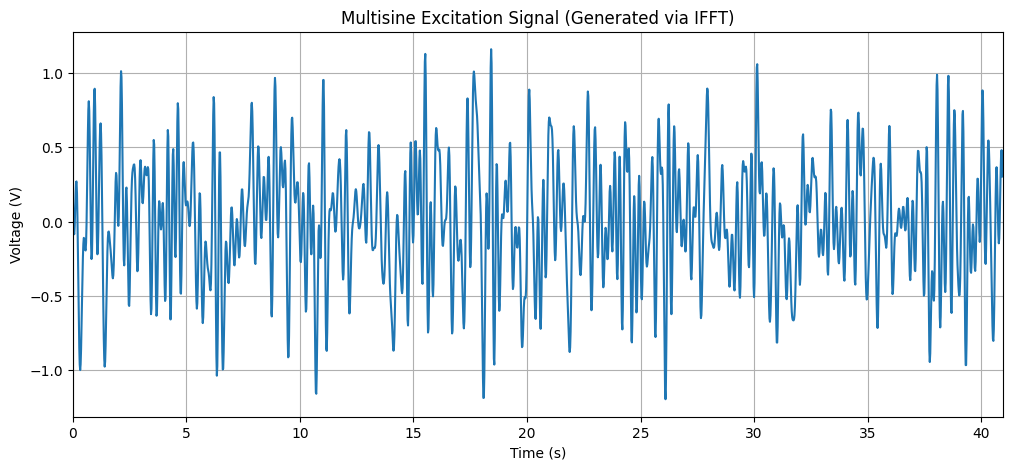

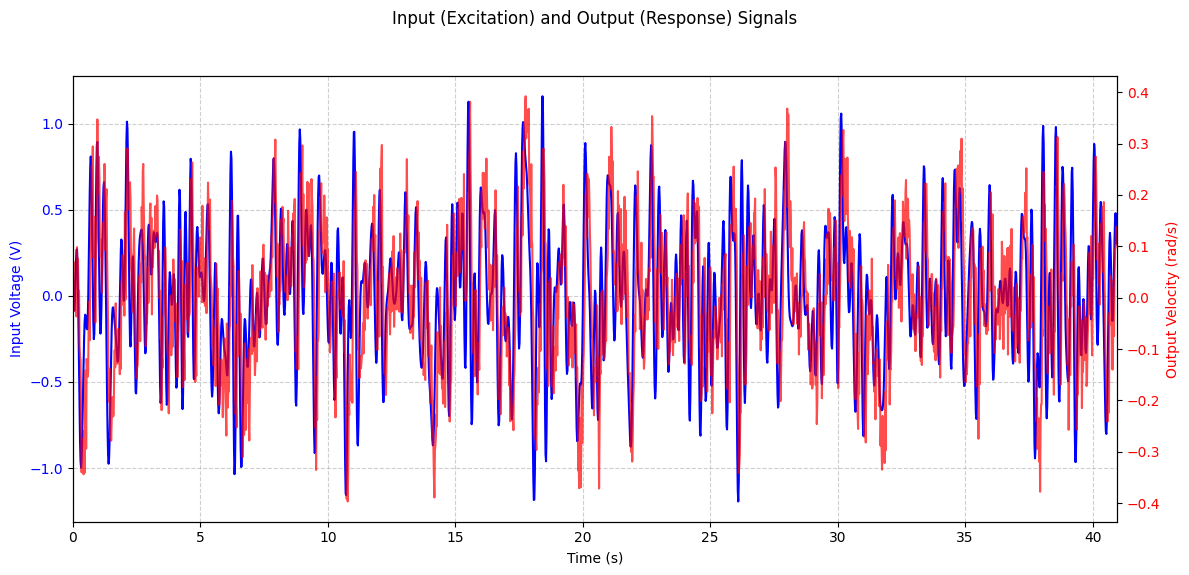

In [ ]:
# Plot the excitation signal
plt.figure(figsize=(12, 5))
plt.plot(t_span_np, u_input_np)
plt.title("Multisine Excitation Signal (Generated via IFFT)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.xlim(0, T)
plt.grid(True)
plt.show()

# Plot the Input vs. Output data
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Input Voltage (V)', color='blue')
ax1.plot(t_span_np, u_input_np, 'b-', label='Input Voltage')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xlim(0, T)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Output Velocity (rad/s)', color='red')
ax2.plot(t_span_np, w_noisy_np, 'r-', markersize=2, alpha=0.7, label='Measured Velocity')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Input (Excitation) and Output (Response) Signals')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Part 3.2: Multiple Shooting Model Implementation

Here we define the core JAX functions for the objective and constraints. The data is reshaped into batches corresponding to the multiple shooting intervals. A key element is the use of `diffrax.LinearInterpolation` to handle the time-varying input signal within the differentiable ODE solver.

In [ ]:
# Choose n_shots to be a divisor of N (2048). We use 64.
# 2048 / 64 = 32 data points per shot.
n_shots = 64
n_timesteps_per_shot = len(t_span_np) // n_shots

# Reshape data into batches for multiple shooting
t_shots = jnp.array(t_span_np.reshape(n_shots, n_timesteps_per_shot))
y_data = jnp.array(w_noisy_np.reshape(n_shots, n_timesteps_per_shot))

# Create a differentiable interpolation object for the input signal
u_interpolation = LinearInterpolation(ts=t_span_np, ys=u_input_np)

# The JAX-compatible model evaluates the interpolated input u at any time t
def dc_motor_model_jax(t, w, args):
    theta1, theta2, u_interp = args
    u = u_interp.evaluate(t)
    return theta1 * w + theta2 * u

term = ODETerm(dc_motor_model_jax)
solver = Dopri5()

def create_loss_and_constraint_fns(t_shots, y_data, u_interp):
    """A factory to create the objective and constraint functions."""
    @jax.jit
    def objective_jax(decision_vars):
        theta1, theta2 = decision_vars[:2]
        w_initial_shots = decision_vars[2:]

        def simulate_shot(t_shot, w0):
            saveat = SaveAt(ts=t_shot)
            args = (theta1, theta2, u_interp)
            sol = diffeqsolve(term, solver, t0=t_shot[0], t1=t_shot[-1], dt0=0.01, y0=w0, saveat=saveat, args=args)
            return sol.ys.flatten()

        w_pred = jax.vmap(simulate_shot)(t_shots, w_initial_shots)
        return jnp.sum((w_pred - y_data)**2)

    @jax.jit
    def continuity_constraints_jax(decision_vars):
        theta1, theta2 = decision_vars[:2]
        w_initial_shots = decision_vars[2:]

        def get_end_state(t_shot, w0):
            args = (theta1, theta2, u_interp)
            sol = diffeqsolve(term, solver, t0=t_shot[0], t1=t_shot[-1], dt0=0.01, y0=w0, args=args)
            return sol.ys[-1]

        w_end_of_shots = jax.vmap(get_end_state)(t_shots[:-1], w_initial_shots[:-1])
        return (w_end_of_shots - w_initial_shots[1:]).flatten()

    return objective_jax, continuity_constraints_jax

# Create the specific functions for our data
objective_jax, continuity_constraints_jax = create_loss_and_constraint_fns(t_shots, y_data, u_interpolation)

# Create JIT-compiled gradient and Jacobian functions
objective_grad_func = jax.jit(jax.value_and_grad(objective_jax))
# We use jacrev (reverse-mode AD) as it's compatible with the adjoint-based diffrax solver
constraints_jac_func = jax.jit(jax.jacrev(continuity_constraints_jax))

### Part 3.3: Parameter Identification and Results

With all components defined, we run the `scipy.optimize.minimize` solver. Wrapper functions are used to interface between SciPy's NumPy-based inputs and our JAX-based functions. A `tqdm` progress bar provides feedback on the optimization progress.

In [ ]:
# Wrapper functions to interface between SciPy (NumPy) and JAX
def obj_for_scipy(dv_np):
    val, grad = objective_grad_func(jnp.array(dv_np))
    return np.array(val), np.array(grad)

def cons_for_scipy(dv_np):
    return np.array(continuity_constraints_jax(jnp.array(dv_np)))

def cons_jac_for_scipy(dv_np):
    return np.array(constraints_jac_func(jnp.array(dv_np)))

# Set up the optimization problem
initial_guess_np = np.concatenate([[-1.0, 1.0], np.zeros(n_shots)])
cons = ({'type': 'eq', 'fun': cons_for_scipy, 'jac': cons_jac_for_scipy})

# Run the optimization with a progress bar
max_iterations = 1000
with tqdm(total=max_iterations, desc="Optimizing Parameters") as pbar:
    def callback(xk):
        pbar.update(1)

    print("--- Running Optimization with Automatic Differentiation ---")
    result = minimize(obj_for_scipy,
                      initial_guess_np,
                      method='SLSQP',
                      jac=True, # Tells SciPy that our objective function returns value and gradient
                      constraints=cons,
                      options={'maxiter': max_iterations, 'disp': False}, # Set disp=False for cleaner output with tqdm
                      callback=callback)

print("\nOptimization finished with status:", result.message)

Optimizing Parameters:   0%|          | 0/1000 [00:00<?, ?it/s]

--- Running Optimization with Automatic Differentiation ---


Optimizing Parameters:   1%|          | 12/1000 [00:33<45:42,  2.78s/it]


Optimization finished with status: Optimization terminated successfully


In [ ]:
# Extract and display results
theta1_est, theta2_est = result.x[:2]

print("\n--- Identification Results ---")
print(f"True parameters:      theta1 = {theta1_true:.4f}, theta2 = {theta2_true:.4f}")
print(f"Estimated parameters: theta1 = {theta1_est:.4f}, theta2 = {theta2_est:.4f}")

# Simulate the final model prediction
final_args = (theta1_est, theta2_est, u_interpolation)
final_sol = diffeqsolve(term, solver, t0=t_span_np[0], t1=t_span_np[-1], dt0=0.01, y0=0.0, saveat=SaveAt(ts=jnp.array(t_span_np)), args=final_args)
w_model_pred = final_sol.ys.flatten()



--- Identification Results ---
True parameters:      theta1 = -10.0000, theta2 = 5.0000
Estimated parameters: theta1 = -10.2451, theta2 = 5.1467


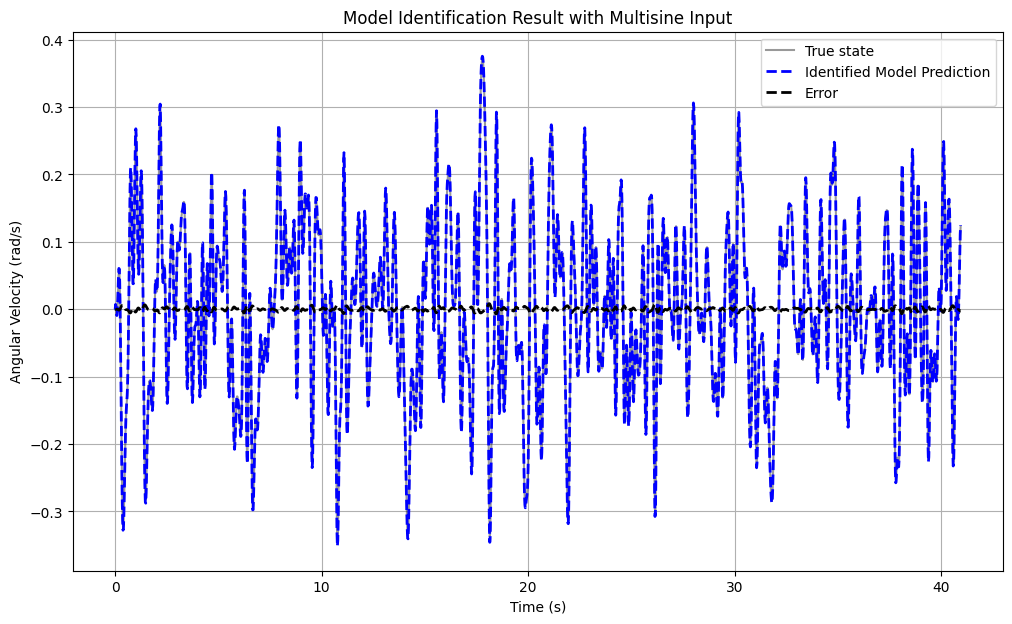

In [ ]:
# Plot final results
plt.figure(figsize=(12, 7))
plt.plot(t_span_np, w_true, 'k', label='True state', alpha=0.4)
plt.plot(t_span_np, w_model_pred, 'b--', label='Identified Model Prediction', linewidth=2)
plt.plot(t_span_np, w_true - w_model_pred, 'k--', label='Error', linewidth=2)
# plt.plot(t_span_np, w_true, 'r--', label='True Velocity', linewidth=2, alpha=0.6) # Uncomment to compare with true velocity
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Model Identification Result with Multisine Input')
plt.legend()
plt.grid(True)
plt.show()

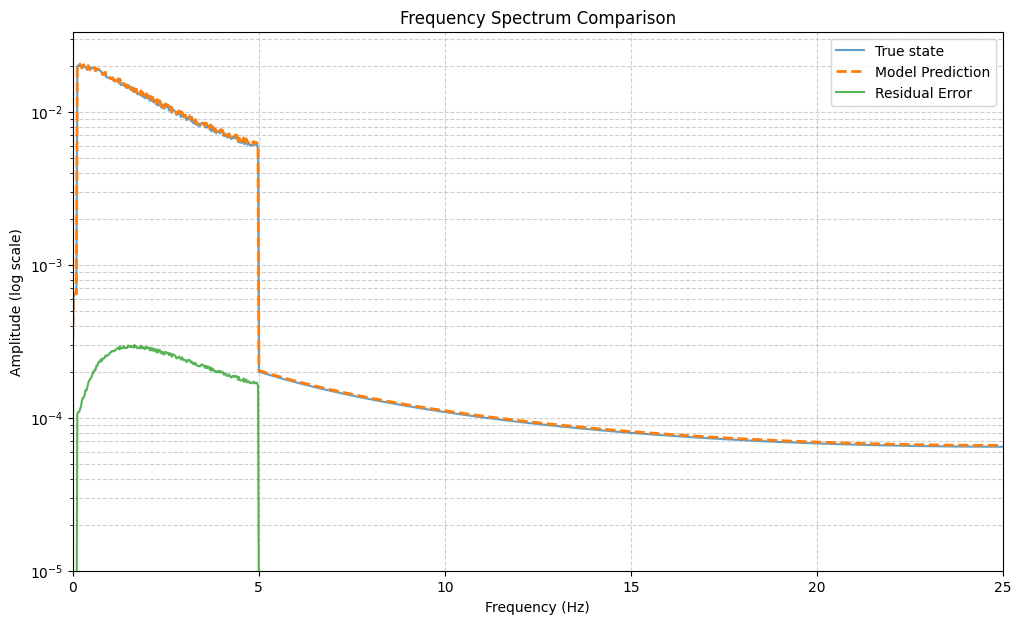

In [ ]:
# First, define the residual signal (the error between measurement and prediction)
w_residual = w_true - w_model_pred

# Helper function to compute the single-sided amplitude spectrum of a signal
def calculate_amplitude_spectrum(signal, sampling_freq):
    """
    Computes the single-sided amplitude spectrum of a signal using FFT.

    Args:
        signal (np.ndarray): The input time-domain signal.
        sampling_freq (float): The sampling frequency in Hz.

    Returns:
        tuple: A tuple containing the frequencies (Hz) and the amplitudes.
    """
    N = len(signal)
    if N == 0:
        return np.array([]), np.array([])

    # Compute the Fast Fourier Transform
    fft_vals = np.fft.fft(signal)

    # Compute the frequency bins
    freqs = np.fft.fftfreq(N, 1 / sampling_freq)

    # We only care about the positive frequencies for the single-sided spectrum
    positive_freq_indices = np.where(freqs >= 0)
    freqs = freqs[positive_freq_indices]
    fft_vals = fft_vals[positive_freq_indices]

    # Calculate the amplitude
    # The amplitude is scaled by 2/N to account for energy in negative frequencies.
    # The DC component (at freq=0) is not doubled.
    amplitudes = np.abs(fft_vals) / N
    if N > 1:
      amplitudes[1:] *= 2

    return freqs, amplitudes

# Calculate the spectrum for each signal
freqs, amp_w = calculate_amplitude_spectrum(w_true, fs)
_, amp_pred = calculate_amplitude_spectrum(w_model_pred, fs)
_, amp_residual = calculate_amplitude_spectrum(w_residual, fs)

# --- Plot the Frequency Spectra ---
plt.figure(figsize=(12, 7))

# A semilog plot is best for viewing a wide dynamic range of amplitudes
plt.semilogy(freqs, amp_w, label='True state', alpha=0.7)
plt.semilogy(freqs, amp_pred, label='Model Prediction', linestyle='--', linewidth=2)
plt.semilogy(freqs, amp_residual, label='Residual Error', alpha=0.8)

plt.title('Frequency Spectrum Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (log scale)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xlim(0, fs / 2) # Show up to the Nyquist frequency
plt.ylim(bottom=1e-5) # Set a lower limit to avoid plotting near zero
plt.show()